In [17]:
! pip install --upgrade pandas tensorflow ktrain odfpy

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/11/17/fb1a34f3e73debbc2fd15a01ea17eaab3717943d08463ff4979a4f024b3f/pandas-2.1.4-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-2.1.4-cp311-cp311-win_amd64.whl.metadata (18 kB)
     ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
     --------------------------------------- 0.0/25.3 MB 262.6 kB/s eta 0:01:37
     --------------------------------------- 0.1/25.3 MB 508.4 kB/s eta 0:00:50
     --------------------------------------- 0.1/25.3 MB 654.9 kB/s eta 0:00:39
     --------------------------------------- 0.1/25.3 MB 654.9 kB/s eta 0:00:39
     --------------------------------------- 0.2/25.3 MB 808.4 kB/s eta 0:00:32
     --------------------------------------- 0.2/25.3 MB 808.4 kB/s eta 0:00:32
     ----------------------

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import roc_auc_score
# tensorflow.random.set_seed(2)
import re

In [101]:
df=pd.read_excel("hindi-tweets-dataframe.xlsx")
df.drop(columns=['Column1'],inplace=True)
df

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
1,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
2,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
3,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
4,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
...,...,...
16174,स्वर्गीय श्री सुशांत सिंह राजपूत ने हमें छिछोर...,non_sarcastic
16175,बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लग...,non_sarcastic
16176,#SushantSinghRajput #Suicide क्यों?? चमक धमक ...,non_sarcastic
16177,हर हाल में #खुश रहना सीख लो🙃\n उस दिल क...,non_sarcastic


In [102]:
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True,inplace=True)
df

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
1,Dil hi saaf rakhlo... \nShakal ka to vaise bhi...,sarcastic
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃\...,sarcastic
3,पिछली सरकार के 10 साल के कार्यकाल में 171 जवा...,sarcastic
4,"""Akele aaye the akele hi jayengy"" ye kahawat a...",sarcastic
...,...,...
1127,https://t.co/HnIURjsvMT अंतर्राष्ट्रीय योग दिव...,non_sarcastic
1128,@Jaihindsonu59 @SinghChunni @SATYAPR27477125 क...,non_sarcastic
1129,https://t.co/qzgPRYlS1h प्रदेश में आज से कोरोन...,non_sarcastic
1130,"Zyada achey b mat bano, yad rkho k meethey pha...",non_sarcastic


In [50]:
from indic_transliteration import sanscript
from indic_transliteration.sanscript import SchemeMap
import langid

# Function to detect language and transliterate to Devanagari if the input is in English
def roman_to_devanagari_or_original(text):
    # Detect the language
    lang, _ = langid.classify(text)

    # If the detected language is English, transliterate to Devanagari
    if lang !='hi':
        return sanscript.transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)
    else:
        # If the detected language is not English, return the original text
        return text

In [103]:
df

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
1,Dil hi saaf rakhlo... \nShakal ka to vaise bhi...,sarcastic
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃\...,sarcastic
3,पिछली सरकार के 10 साल के कार्यकाल में 171 जवा...,sarcastic
4,"""Akele aaye the akele hi jayengy"" ye kahawat a...",sarcastic
...,...,...
1127,https://t.co/HnIURjsvMT अंतर्राष्ट्रीय योग दिव...,non_sarcastic
1128,@Jaihindsonu59 @SinghChunni @SATYAPR27477125 क...,non_sarcastic
1129,https://t.co/qzgPRYlS1h प्रदेश में आज से कोरोन...,non_sarcastic
1130,"Zyada achey b mat bano, yad rkho k meethey pha...",non_sarcastic


In [104]:
df2=df.copy()
# df2['text']=df['text'].apply(lambda x: roman_to_devanagari_or_original(x))
df2

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
1,Dil hi saaf rakhlo... \nShakal ka to vaise bhi...,sarcastic
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃\...,sarcastic
3,पिछली सरकार के 10 साल के कार्यकाल में 171 जवा...,sarcastic
4,"""Akele aaye the akele hi jayengy"" ye kahawat a...",sarcastic
...,...,...
1127,https://t.co/HnIURjsvMT अंतर्राष्ट्रीय योग दिव...,non_sarcastic
1128,@Jaihindsonu59 @SinghChunni @SATYAPR27477125 क...,non_sarcastic
1129,https://t.co/qzgPRYlS1h प्रदेश में आज से कोरोन...,non_sarcastic
1130,"Zyada achey b mat bano, yad rkho k meethey pha...",non_sarcastic


In [ ]:
# for i in df.shape[0]:
# lang, _ = langid.classify(df.loc[1,'text'])
# lang
# langid.rank(df.loc[2,'text'])
# df['text']=df['text'].apply(lambda x: roman_to_devanagari_or_original(x))


In [79]:
# import re
# emoji_pattern = re.compile("["                 
#         u"U0001F600-U0001F64F"  # emoticons
#         u"U0001F300-U0001F5FF"  # symbols & pictographs
#         u"U0001F680-U0001F6FF"  # transport & map symbols
#         u"U0001F1E0-U0001F1FF"  # flags (iOS)
#         u"U00002500-U00002BEF"  # chinese char
        
#                            "]+", flags=re.UNICODE)

In [105]:
import re
def processText(text):
    text = text.lower()
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
    text = re.sub('@\S+','',text)
    text = re.sub('[s]+', '', text)
    text = re.sub(r'#\S+', "", text)
    
  
    return text

In [71]:
# textt='''*#ईश्वर #कहते है ….*
# *किसी को #तकलीफ़ देकर*
# *मुझसे अपनी ख़ुशी की*
# *#दुआ मत #करना ,*

# *#लेकिन …*
# *अगर किसी को एक पल #की भी*
# *#ख़ुशी देते हो तो …*
# *#अपनी तकलीफ़ की*
# *फ़िक्र मत #करना……*🙏🏼🌹 https://t.co/IUNG6qo48w '''
# processText(textt)

'*  है ….*\n*किसी को  देकर*\n*मुझसे अपनी ख़ुशी की*\n* मत  ,*\n\n* …*\n*अगर किसी को एक पल  भी*\n* देते हो तो …*\n* तकलीफ़ की*\n*फ़िक्र मत  '

In [106]:
for i in range(len(df)):
#     df2['text'][i] = re.sub(emoji_pattern,"", df2['text'][i])
    df2['text'][i] = processText(df2['text'][i])
    df2['text'][i] = re.sub('\.', '', df2['text'][i])
    df2['text'][i] = re.sub('\n', '', df2['text'][i])
    df2['text'][i] = re.sub('1', '', df2['text'][i])
    df2['text'][i] = re.sub('\*', '', df2['text'][i])
    df2['text'][i] = re.sub('*\n+*', '', df2['text'][i])
    df2['text'][i] = re.sub('@', '', df2['text'][i])
df2

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,sarcastic
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,sarcastic
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,sarcastic
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",sarcastic
...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,non_sarcastic
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,non_sarcastic
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,non_sarcastic
1130,"zyada achey b mat bano, yad rkho k meethey pha...",non_sarcastic


In [107]:
def count_length():
    df2['word_count'] = df2['text'].apply(lambda x: len(str(x).split(" ")))
count_length()
df2

,text,label,word_count
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",sarcastic,58
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,sarcastic,19
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,sarcastic,12
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,sarcastic,28
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",sarcastic,27
...,...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,non_sarcastic,31
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,non_sarcastic,21
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,non_sarcastic,32
1130,"zyada achey b mat bano, yad rkho k meethey pha...",non_sarcastic,18


In [108]:
df2['label'] = df2['label'].map({'sarcastic':0,'non_sarcastic':1})

df2

,text,label,word_count
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0,58
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0,19
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0,12
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0,28
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0,27
...,...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,1,31
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,1,21
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,1,32
1130,"zyada achey b mat bano, yad rkho k meethey pha...",1,18


In [109]:

df2=df2[['text','label']]
df2

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0
...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,1
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,1
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,1
1130,"zyada achey b mat bano, yad rkho k meethey pha...",1


In [139]:
df3=df2[df2['label']==0]
df4=pd.concat([df2,df3,df3,df3], ignore_index=True)
df4

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0
...,...,...
1715,corona e bachne ke liye ghar par rahedepreion ...,0
1716,me : kii ne bataya tum kitni khuburat ho?he : ...,0
1717,ये बन्दर का डांस देखेंगे और वो भी चौराहे पर ...,0
1718,कब पैदा होगा विकास??? bz,0


In [145]:
df4.to_excel("finaldataset.xlsx")

In [2]:
df4=pd.read_excel("finaldataset.xlsx")
df4.drop(columns="Unnamed: 0",inplace=True)
df4

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0
...,...,...
1715,corona e bachne ke liye ghar par rahedepreion ...,0
1716,me : kii ne bataya tum kitni khuburat ho?he : ...,0
1717,ये बन्दर का डांस देखेंगे और वो भी चौराहे पर ...,0
1718,कब पैदा होगा विकास??? bz,0


In [4]:
df4=df4.drop_duplicates()
df4

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0
...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,1
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,1
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,1
1130,"zyada achey b mat bano, yad rkho k meethey pha...",1


In [5]:
df4['label'].value_counts()

label
1    913
0    190
Name: count, dtype: int64

In [6]:
df4=df4.drop(index=df4[df4['text'].apply(lambda x: x.isspace())==True].index)
df4

,text,label
0,"हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...",0
1,dil hi aaf rakhlo hakal ka to vaie bhi kuchh n...,0
2,घोड़ो को ना मिली घास और गधे खा रहे चवनप्रास😃😃,0
3,पिछली सरकार के 0 साल के कार्यकाल में 7 जवान श...,0
4,"""akele aaye the akele hi jayengy"" ye kahawat a...",0
...,...,...
1127,vmt अंतर्राष्ट्रीय योग दिवस के उपलक्ष में फिट ...,1
1128,कितने है ये दिन और सूनी हर पल का तुम्हे ...,1
1129,h प्रदेश में आज से कोरोना के प्रति जन जागरूकता...,1
1130,"zyada achey b mat bano, yad rkho k meethey pha...",1


In [40]:
df4['text']=df4['text'].apply(lambda x: x.lower())

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Assuming X_train is your text data and y_train is the corresponding labels
X_train, X_test, y_train, y_test = train_test_split(df4['text'], df4['label'], random_state=91, test_size=0.2)

# Create a new instance of TfidfVectorizer and fit_transform on the raw text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Apply SMOTE to the TF-IDF features
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train a classifier on the resampled data
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

# Transform the test data using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Evaluate the classifier on the test set
y_test_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.36      0.41      0.38        34
           1       0.89      0.87      0.88       187

    accuracy                           0.80       221
   macro avg       0.62      0.64      0.63       221
weighted avg       0.81      0.80      0.80       221



In [41]:
X_train, X_test, y_train, y_test = train_test_split(df4['text'], df4['label'], random_state=91, test_size=0.2)
print ("Training sample size:", X_train.size)
print ("Validation dataset size:", X_test.size)
print("Training labels:", set(y_train.values))

Training sample size: 881
Validation dataset size: 221
Training labels: {0, 1}


In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# cntvectorizer=CountVectorizer()
# bag_of_words=cntvectorizer.fit_transform(df4['text'])
# Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [45]:
X_test_tfidf

<221x2724 sparse matrix of type '<class 'numpy.float64'>'
	with 1887 stored elements in Compressed Sparse Row format>

In [13]:
!pip install imbalanced-learn


In [46]:
from imblearn.over_sampling import SMOTE
from imblearn.utils._validation import _check_X
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)


In [34]:
y_resampled.value_counts()

label
1    725
0    725
Name: count, dtype: int64

In [47]:
def Model(model, x_train, x_test, y_train, y_test):
#training and testing the data
        pipeline_model=model

        pipeline_model.fit(x_train, y_train)

        y_pred = pipeline_model.predict(x_test)
        y_probas =pipeline_model.predict_proba(x_test)
        skplt.metrics.plot_roc(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
        plt.show()
        skplt.metrics.plot_precision_recall(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
        plt.show()

        print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
        print("Classification Report is:\n",classification_report(y_test, y_pred))
        print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
        print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)

In [91]:
train_scores=dict()
test_scores=dict()

In [80]:
def training_scores(model,y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    train_scores[str(model)]=acc
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')

def validation_scores(model,y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    test_scores[str(model)]=acc
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    training_scores(model,y_train, y_train_pred)
    validation_scores(model,y_test, y_test_pred)
    print("Classification Report is:\n",classification_report(y_test, y_test_pred))
    cm=confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(5,3))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="OrRd")

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
#     ax.set_title('EMODB-CNN'); 
    ax.xaxis.set_ticklabels(['0','1']);
    ax.yaxis.set_ticklabels(['0','1']);

Training Scores: Accuracy=0.948, F1-Score=0.949
Validation Scores: Accuracy=0.796, F1-Score=0.878
Classification Report is:
               precision    recall  f1-score   support

           0       0.36      0.41      0.38        34
           1       0.89      0.87      0.88       187

    accuracy                           0.80       221
   macro avg       0.62      0.64      0.63       221
weighted avg       0.81      0.80      0.80       221



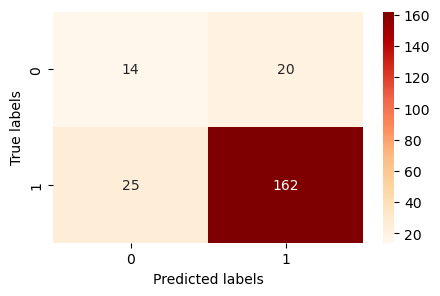

In [92]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
train_and_evaluate(lr, X_resampled, y_resampled, X_test_tfidf,y_test)

In [93]:
test_scores

{'LogisticRegression()': 0.796}

Training Scores: Accuracy=0.93, F1-Score=0.928
Validation Scores: Accuracy=0.765, F1-Score=0.85
Classification Report is:
               precision    recall  f1-score   support

           0       0.35      0.65      0.46        34
           1       0.92      0.79      0.85       187

    accuracy                           0.76       221
   macro avg       0.64      0.72      0.65       221
weighted avg       0.84      0.76      0.79       221



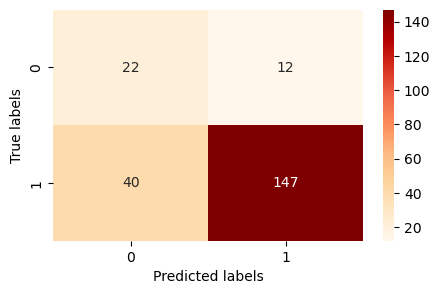

In [94]:
# Naive Bayes Classifier
mnb = MultinomialNB()
train_and_evaluate(mnb, X_resampled, y_resampled, X_test_tfidf,y_test)

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.855, F1-Score=0.92
Classification Report is:
               precision    recall  f1-score   support

           0       0.60      0.18      0.27        34
           1       0.87      0.98      0.92       187

    accuracy                           0.86       221
   macro avg       0.73      0.58      0.60       221
weighted avg       0.83      0.86      0.82       221



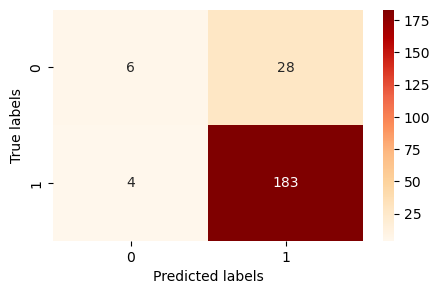

In [95]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
train_and_evaluate(rf, X_resampled, y_resampled, X_test_tfidf,y_test)


Training Scores: Accuracy=0.984, F1-Score=0.984
Validation Scores: Accuracy=0.796, F1-Score=0.885
Classification Report is:
               precision    recall  f1-score   support

           0       0.13      0.06      0.08        34
           1       0.84      0.93      0.89       187

    accuracy                           0.80       221
   macro avg       0.49      0.49      0.48       221
weighted avg       0.74      0.80      0.76       221



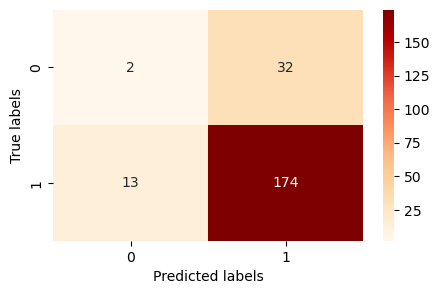

In [102]:
# Extreme Gradient Boosting Classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_and_evaluate(xgb, X_resampled, y_resampled, X_test_tfidf,y_test)

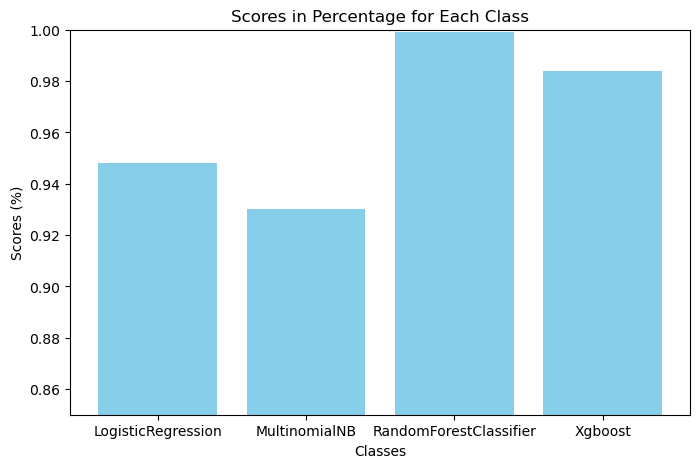

In [106]:
import matplotlib.pyplot as plt

# Example dictionary with scores in percentages
# Extract keys and values from the dictionary
classes = ['LogisticRegression','MultinomialNB','RandomForestClassifier','Xgboost' ]
percentages = list(train_scores.values())

plt.figure(figsize=(8, 5))  # Adjust the size as needed
plt.bar(classes, percentages, color='skyblue')

# Set y-axis limits
plt.ylim(.85, 1)

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores (%)')
plt.title('Scores in Percentage for Each Class')

# Display the plot
plt.show()

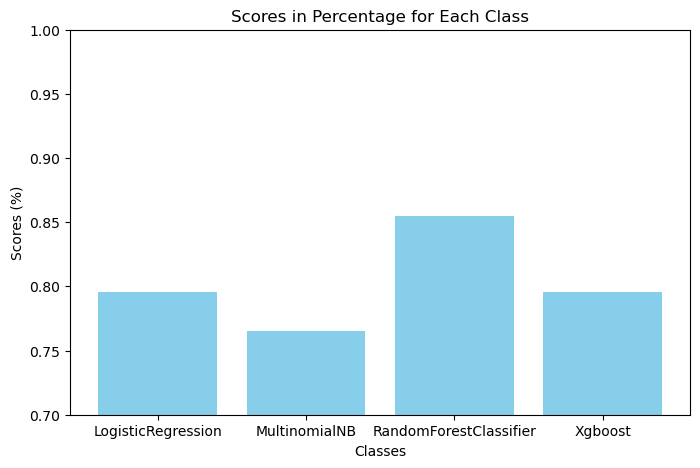

In [108]:
import matplotlib.pyplot as plt

# Example dictionary with scores in percentages
# Extract keys and values from the dictionary
classes = ['LogisticRegression','MultinomialNB','RandomForestClassifier','Xgboost' ]
percentages = list(test_scores.values())

plt.figure(figsize=(8, 5))  # Adjust the size as needed
plt.bar(classes, percentages, color='skyblue')

# Set y-axis limits
plt.ylim(.7, 1)

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Scores (%)')
plt.title('Scores in Percentage for Each Class')

# Display the plot
plt.show()

In [112]:
import ktrain
from ktrain import text
t = text.Transformer("monsoon-nlp/hindi-bert", maxlen=500, class_names=list(set(y_train.values)))

In [142]:
trn = t.preprocess_train(X_train.to_numpy(), y_train.to_numpy())

preprocessing train...
language: hi
train sequence lengths:
	mean : 22
	95percentile : 48
	99percentile : 56


Is Multi-Label? False


In [143]:
evalr = t.preprocess_test(X_test.to_numpy(), y_test.to_numpy())

preprocessing test...
language: hi
test sequence lengths:
	mean : 22
	95percentile : 50
	99percentile : 55


In [146]:
model = t.get_classifier()
learner = ktrain.get_learner (model, train_data=trn, val_data=evalr, batch_size=20, use_multiprocessing=True, workers=1)
learner.fit_onecycle(1.2e-4, 3)



begin training using onecycle policy with max lr of 0.00012...
Epoch 1/3
34/69 [=============>................] - ETA: 18:23 - loss: 0.6890 - accuracy: 0.5471

KeyboardInterrupt: 

In [116]:
learner.view_top_losses(n=5, preproc=t)

8/8 [==============================] - 24s 2s/step
----------
id:108 | loss:1.81 | true:0 | pred:1)

----------
id:33 | loss:1.81 | true:0 | pred:1)

----------
id:217 | loss:1.81 | true:0 | pred:1)

----------
id:27 | loss:1.8 | true:0 | pred:1)

----------
id:219 | loss:1.8 | true:0 | pred:1)



In [117]:
val = learner.validate(evalr, class_names=list(set(y_train.values)))

8/8 [==============================] - 17s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.85      1.00      0.92       192

    accuracy                           0.85       227
   macro avg       0.42      0.50      0.46       227
weighted avg       0.72      0.85      0.78       227



C:\Users\muska\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,y_predict)
cm

array([[  0,  35],
       [  0, 192]], dtype=int64)

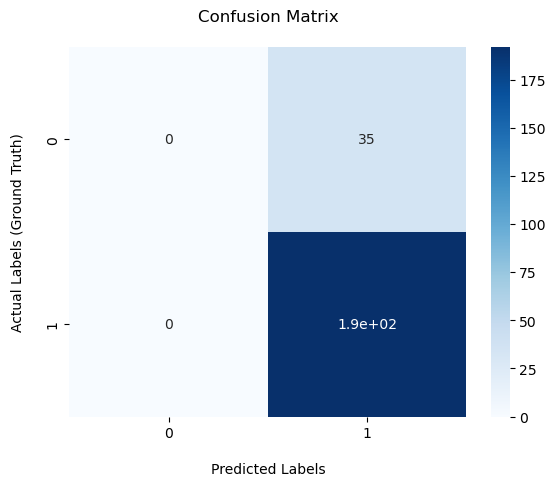

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ax = sns.heatmap(val, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels (Ground Truth)\n');

## Ticket labels
ax.xaxis.set_ticklabels(list(set(y_train.values)))
ax.yaxis.set_ticklabels(list(set(y_train.values)))

## Display the visualization of the Confusion Matrix.
plt.show()

In [120]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [121]:
y_predict=[]
for i in X_test:
    y_predict.append(predictor.predict(i))
cnt=0
y_test_list=list(y_test)
for i in range(len(y_predict)):
    if y_test_list[i]!=y_predict[i]:
        cnt+=1


In [123]:
accuracy_percentage = ((len(y_predict) - cnt) / len(y_predict)) * 100
print("accuracy: {:.2f}%".format(accuracy_percentage))


accuracy: 84.58%


In [132]:
learner.save_model('monsoonnlp.h5')

In [135]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('monsoonnlp\\tf_model.h5')


ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000021B797D9E50>.